# LINEAR REGRESSION

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import mediapipe
from functions import *
drawingModule = mediapipe.solutions.drawing_utils
handsModule = mediapipe.solutions.hands



videos_dir = 'videos-to-process/'
data_dir = 'data/'
videos = ['palm_a.mp4', 'palm_j.mp4', 'fist_a.mp4', 'fist_j.mp4']
video_classes = ['palm', 'palm', 'fist', 'fist']
my_classes = {'palm':0, 'fist':1}



# for ind, video in enumerate(videos):
#     #crea los frames de los videos y los guarda en el directorio data
#     video_to_images(videos_dir+video, data_dir, video_classes[ind], ind)


atributes = ['top angle', 'middle angle', 'bottom angle']
target = 'class'

col = atributes+[target]
dataset = dataset_angles(data_dir, my_classes)

# ahora tengo todos los datos en una lista de tuplas, cada tupla es de 2 elementos, los angulos de todos los dedos de una imagen y su clase
# el 1º elemento de la tupla es un diccionario que tiene como clave el indice del dedo (si es el indice=0, anular=2, etc) y como valor otro diccionario
# este otro diccionario tiene como clave el indice del angulo (superior=0, medio=1, inferior=2) y como valor el angulo en grados

#ahora valos a crear 4 datasets para los 4 modelos (uno por cada dedo)
data_frames = []
for i in range(4):
    data_frames.append(pd.DataFrame(columns=col))

#para los 4 dedos:
for im in dataset:
    for f in range(4):
        entry = im[0][f]
        entry.append(im[1])
        data_frames[f].loc[len(data_frames[f])] = entry





### Dataframe de los angulos de las articulaciones de un dedo

In [2]:
data_frames[0]

,top angle,middle angle,bottom angle,class
0,132.838339,172.521622,157.786395,0.0
1,132.568429,172.353556,157.900961,0.0
2,131.997355,172.588453,160.178676,0.0
3,133.310294,173.015839,159.568185,0.0
4,133.520204,173.228189,159.114632,0.0
...,...,...,...,...
61,143.877067,139.958097,89.697246,1.0
62,120.221824,64.333957,119.356103,1.0
63,115.217105,75.397800,105.390134,1.0
64,118.545439,68.471966,118.660265,1.0


### GRAFICO DE DISPERSION
generamos una nube de puntos para ver la correlacion entre una de las articulaciones y la clase (si las falanges estan extendidas o flexionadas)

C:\Users\joelq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<AxesSubplot: xlabel='middle angle', ylabel='class'>

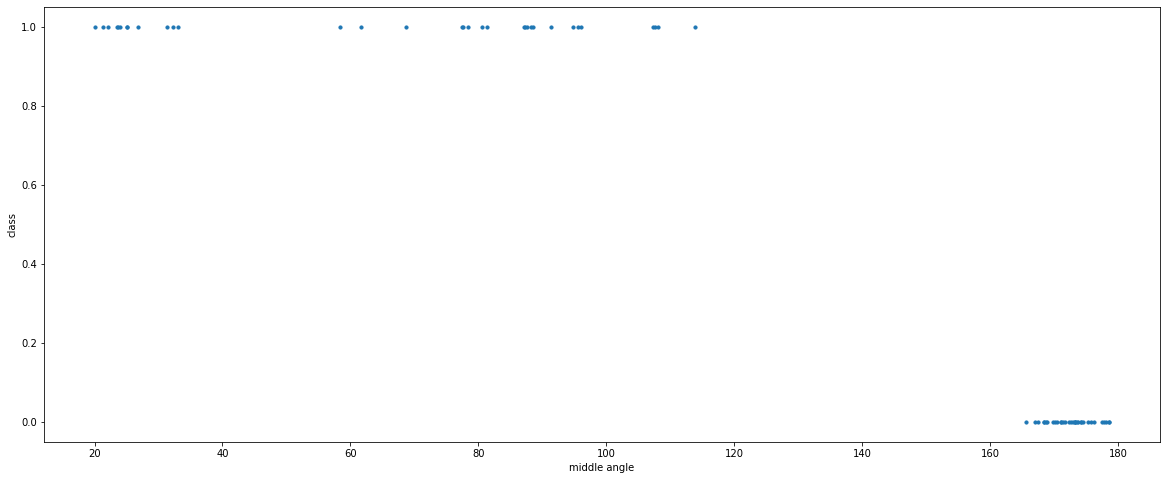

In [3]:
#ejemplo de la articulacion del medio del dedo manular
data_frames[2].plot.scatter(figsize=(20, 8), s=10, x='middle angle', y='class')

### Regresion lineal y evaluacion (MSE Y R^2)
Segun un analisis, escogemos un modelo de regresion lineal.

In [6]:
from sklearn.model_selection import train_test_split
#entrenar modelo para el dedo indice=2

X = data_frames[0][data_frames[0].columns[:-1]]
y = data_frames[0][data_frames[0].columns[-1]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# Creación del modelo de regresión lineal
model = LinearRegression()

# Entrenamiento del modelo
model.fit(X_train, y_train)

# Predicción en el conjunto de prueba
y_pred = model.predict(X_test)

# Evaluación del modelo
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Error cuadrático medio (MSE):", mse)
print("Coeficiente de determinación (R^2):", r2)

# Validación cruzada (añadir muchos mas datos para aplicar esta evaluacion)
#cv_scores = cross_val_score(model, X, y, cv=3)  # 5-fold cross-validation

# print("Puntuaciones de validación cruzada:", cv_scores)
# print("Puntuación media de validación cruzada:", np.mean(cv_scores))

Error cuadrático medio (MSE): 0.01046541026097699
Coeficiente de determinación (R^2): 0.9544173241966335


Segun la evaluacion tenemos un error casi imperceptible, por lo tanto nuestro modelo queda validado

### Ejemplo de prediccion
Probamos un ejemplo de una imagen donde tenemos el dedo anular extendido, y por lo tanto el servomotor de ese dedo no tiene
que tirar del tendon, asi que deberia predecir un valor ≈ 0%

In [15]:
#ejemplo de prediccion de la foto de una mano, para el dedo anular
#(en la foto la mano esta abierta por tanto del rango 0-1 tiene que ser masomenos 0)
import mediapipe as mp
mp_hands = mp.solutions.hands
with mp_hands.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence=0.5) as hands:
    image = cv.imread('m3.JPEG')
    # Convert the BGR image to RGB before processing.
    results = hands.process(cv.cvtColor(image, cv.COLOR_BGR2RGB))
    if not results.multi_hand_landmarks:
        print(f'NO RESULTS:')
    angles = calculate_the_angles(results.multi_hand_landmarks[0])
    m = [(angles,0.80)]

dm = pd.DataFrame(columns=col)
entry = im[0][f]
entry.append(im[1])
dm.loc[len(dm)] = angles[2]+[0.8]
dm[dm.columns[:-1]]
y_pred = model.predict(dm[dm.columns[:-1]])
print(f' el tendon tiene que y_pred: {y_pred[0]*100:.2f}%')


 el tendon tiene que y_pred: -7.26%
